# Log-Euclidean and DTI Processing Introduction

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


from inputs.transformers import ToNumpyArray
from scipy.stats import ortho_group
from torchvectorized import vlinalg
from typing import List
from vizualization.slices import ImageSlicer, SliceType, plot_slices
from vizualization.tensors import plot_tensor
from utils.trk_2_binary import tract_to_binary

%matplotlib inline
plt.rcParams["axes.grid"] = False

In [2]:
# Defining constants and paths
DATA_FOLDER = "data"

DTI_IMAGE_FILE_NAME = "dti.nrrd"
DTI_IMAGE_PATH = os.path.join(DATA_FOLDER, DTI_IMAGE_FILE_NAME)

T1_IMAGE_FILE_NAME = "t1.nii.gz"
T1_IMAGE_PATH = os.path.join(DATA_FOLDER, T1_IMAGE_FILE_NAME)

T1_MNI_FILE_NAME = "T1_MNI.nii.gz"
T1_MNI_IMAGE_PATH = os.path.join(DATA_FOLDER, T1_MNI_FILE_NAME)

BRAIN_MASK_FILE_NAME = "brain_mask.nii.gz"
BRAIN_MASK_IMAGE_PATH = os.path.join(DATA_FOLDER, BRAIN_MASK_FILE_NAME)

TRACT_FILE_NAME = "AF_left.trk"
TRACT_IMAGE_PATH = os.path.join(DATA_FOLDER, TRACT_FILE_NAME)

BINARY_TRACT_FILE_NAME = "AF_left.nii.gz"
BINARY_TRACT_IMAGE_PATH = os.path.join(DATA_FOLDER, BINARY_TRACT_FILE_NAME)

# DTI in a Nutshell

The water molecules in the brain are in constant motion. This fluid motion can be analyzed to determine in a non-invasive manner the connectivity of the brain and its fiber organization. Diffusion weighted imaging (DWI) provides information about the particles’ diffusivity in the brain along the standard Cartesian planes (x, y, z) by applying subsequent magnetic gradients in the direction of these planes and observing the signal loss. The observed **diffusivity is higher in the direction parallel to the structure in which the fluid is moving and lower in the perpendicular direction**. 

**Axons (the biological structure connecting the neurons in the brain) are tubular shaped, thus their inner fluid diffusivity is constrained along their orientation.** The highest observed diffusivity should be parallel to their direction and the lowest observed diffusivity must be perpendicular. However, DWI only provides the diffusivity measures along x, y and z which are barely ever the axons’ orientation. To solve this issue, the concept of diffusion tensor was introduced (Basser & Jones, 2002).

<img src="images/axons.jpg" width="800" vertical-align="bottom">

In the tensor imaging model, the diffusivity measurements along different axes are fitted to a **3D ellipsoid defined by 6 parameters (three eigenvectors and three eigenvalues)** (Mori & Zhang, 2006). The eigenvalues vary depending on the diffusivity in the associated eigenvectors direction. From these six parameters, multiple observations can be made such as the degree of diffusion anisotropy (Mori & Zhang, 2006). 

The eigenvectors and eigenvalues are extracted from the diagonalization of the normalized 3D diffusivity displacement matrix D.
<img src="images/diffusion_tensor.jpg" width="800" vertical-align="bottom">

## Part #1 Visualization

In [3]:
to_numpy_array = ToNumpyArray()

dti = to_numpy_array(DTI_IMAGE_PATH)
t1 = to_numpy_array(T1_IMAGE_PATH)

print("The T1 image shape is: {}".format(t1.shape))
print("The DTI image shape is: {}".format(dti.shape))

The T1 image shape is: (1, 260, 311, 260)
The DTI image shape is: (9, 124, 162, 119)


- Our first observation is that the T1 image has 1 channel and that **the DTI image has 9 channels**. The channels represent the 9 values of the 3x3 SPD matrix D.
- Our second observation is that the **resolution of the DTI image is much lower than the T1 image's resolution**. This is due to the multi-echo parallel echo planar imaging (EPI) acquisition strategy used to acquire DTI images. Indeed, 

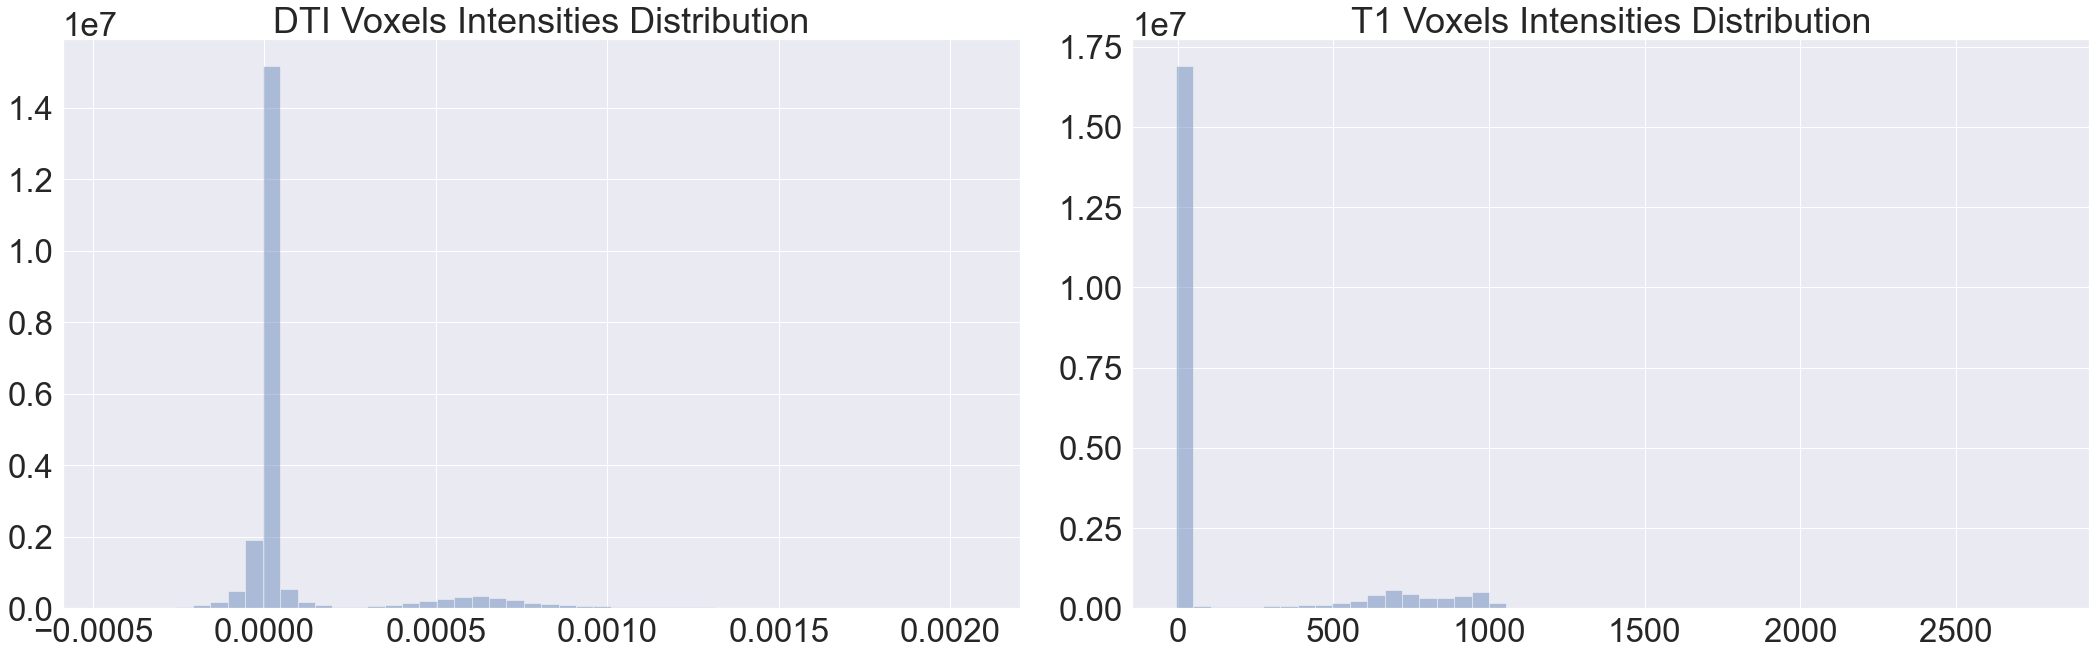

In [4]:
sns.set(font_scale=3)
fig, ax = plt.subplots(1,2, figsize=(30,10))
sns.distplot(dti, bins=50, kde=False, ax=ax[0]).set_title("DTI Voxels Intensities Distribution")
sns.distplot(t1, bins=50, kde=False, ax=ax[1]).set_title("T1 Voxels Intensities Distribution")
plt.tight_layout()

In [5]:
print("T1 Min: {}, Max: {}, Mean: {}, : Std: {}".format(t1.min(), t1.max(), t1.mean(), t1.std()))
print("DTI Min: {}, Max: {}, Mean: {}, : Std: {}".format(dti.min(), dti.max(), dti.mean(), dti.std()))

T1 Min: -5.399068355560303, Max: 2788.93359375, Mean: 141.43162287881563, : Std: 301.60252589192703
DTI Min: -0.0004612022312358022, Max: 0.002075240248814225, Mean: 8.677709828095759e-05, : Std: 0.00024846967637727333


**The range of values differs a lot between T1 and DTI modality.** Here, the T1 voxels' intensities vary between -5.39 and 2788.94 and the DTI voxels intensities are in the range [-0.0004612, 0.002075]. **These differences should be taken into account when designing algorithms.**

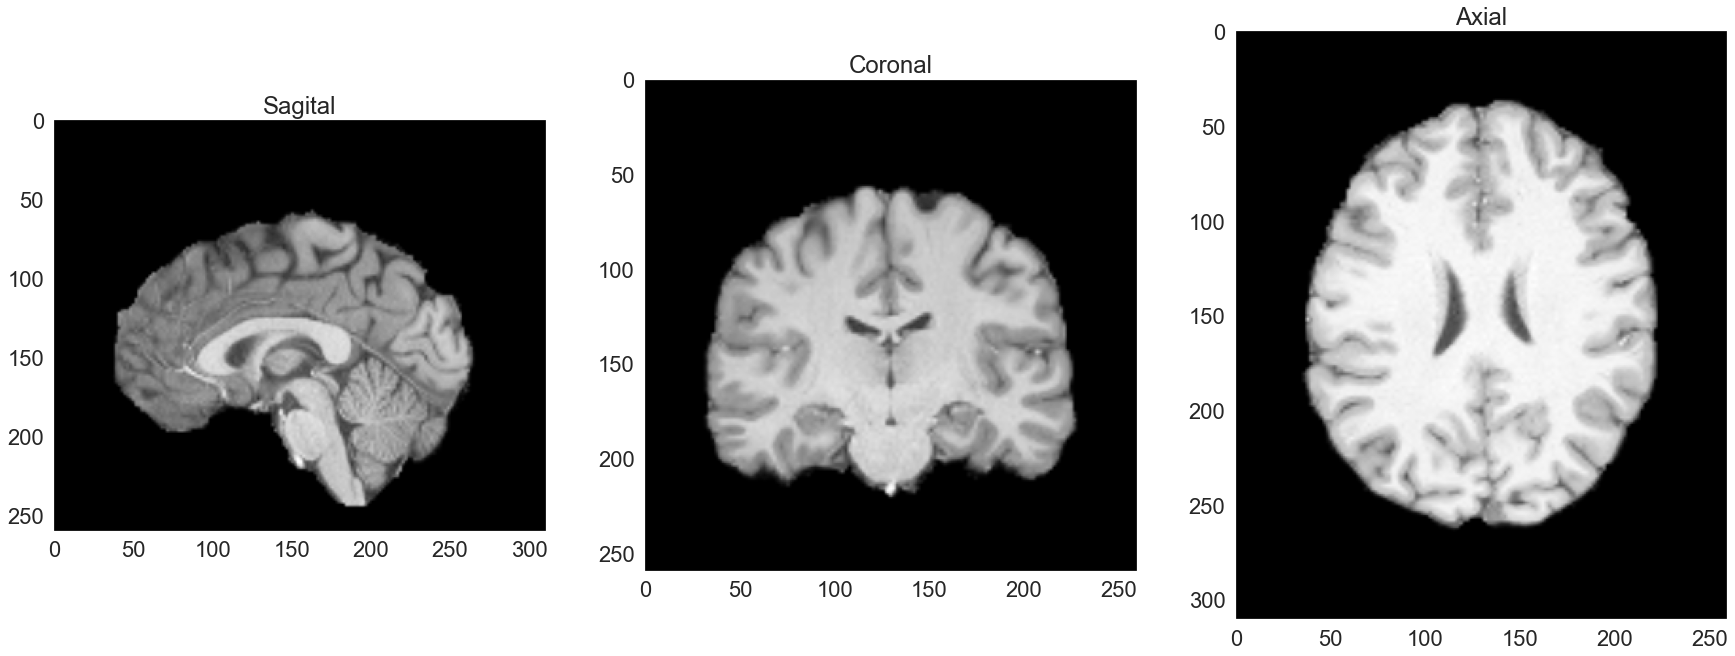

In [6]:
# Slice the T1 volume
t1_sagital = ImageSlicer.get_slice(t1, SliceType.SAGITAL)[0]
t1_coronal = ImageSlicer.get_slice(t1, SliceType.CORONAL)[0]
t1_axial = ImageSlicer.get_slice(t1, SliceType.AXIAL)[0]

plot_slices(t1_sagital,t1_coronal, t1_axial, cmap="Greys_r")

Here we visualize a T1 image using standard planes (Sagital, Coronal and Axial). 

<img src="images/plane.jpg" width="300" vertical-align="bottom">


As **every voxel in a DTI image is a tensor and not a scalar** as in T1 images, we cannot directly visualize them. **Each tensor encodes 3 orientations (eigen vectors) and 3 associated diffusion coefficient (eigen values).**

To visualize DT images multiple options are available:
 - Compute DT derived scalar maps (e.g. fractional anisotropy (FA), mean diffusivity (MD), etc.)
 - Combine a DT derived scalar map and color orientation
 - Vizualize each tensor as a line, tube or ellipse.

## Single Tensor Visualization

In [7]:
# Read a random tensor from the DTI image
tensor = dti[:, 100,100,100]

print("The tensor shape is: {}".format(tensor.shape))

The tensor shape is: (9,)


**A tensor is made of 9 values where 6 of them are unique.** One can consider the 9 values as channel values just as RGB channels.

In [8]:
# Reshape the tensor to 3x3 matrix
tensor = tensor.reshape(3,3)
tensor.reshape(3,3)

array([[4.91604034e-04, 2.07695143e-06, 3.72989075e-06],
       [2.07695143e-06, 5.77396189e-04, 4.02346959e-05],
       [3.72989075e-06, 4.02346959e-05, 5.43117465e-04]])

**As the tensors are SPD, the off-diagonal elements are the same above and below the diagonal.** Only 6 values are unique (3 diagonal elements + 3 off-diagonal elements).

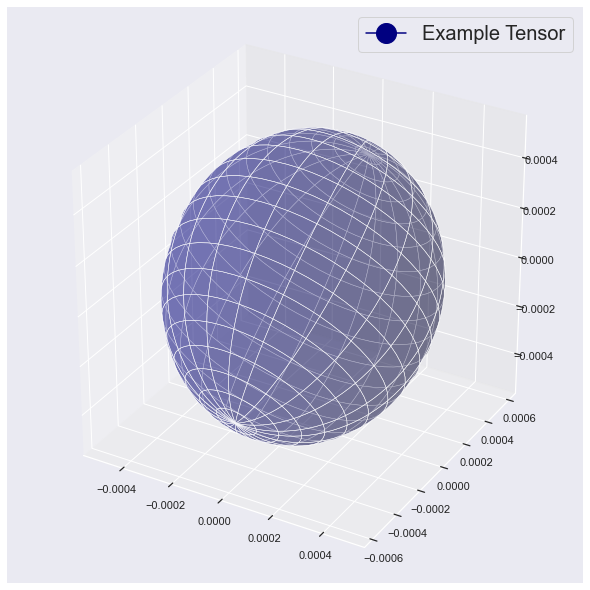

In [9]:
sns.set(font_scale=1)
plot_tensor([tensor], descriptions=["Example Tensor"])

The selected tensor is represented by the above ellipse. **This ellipse is oriented in the principal eigenvector's direction and it's shape is defined by the tensor's eigenvalues.** When eigenvalue1 >> eigenvalue2 >> eigenvalue3 we say that the diffusion is anisotropic (i.e. the water movement is very constrained). When eigenvalue1 ~= eigenvalue2 ~= eigenvalue3, we say that the diffusion is isotropic.

## Tensor Decomposition

The decomposition of a tensor in eigenvectors and eigenvalues is defined by:

$$D = UVU^{T}$$

where $D$ is a tensor, $U$ is a 3x3 matrix of eigenvectors and $V$ is a 3x3 diagonal matrix of eigenvalues.

In [10]:
# Decomposing the tensor in 3 eigenvectors and 3 eigenvalues
eig_vals, eig_vecs = np.linalg.eigh(tensor)

print("The tensor's eigenvectors are: {}".format(eig_vecs))
print("The tensor's eigenvalues are: {}".format(eig_vals))

The tensor's eigenvectors are: [[ 0.99640955  0.07767971 -0.03367313]
 [ 0.01491379 -0.55254692 -0.83334836]
 [-0.08334024  0.82985406 -0.55172152]]
The tensor's eigenvalues are: [0.00049132 0.00051668 0.00060412]


The tensor has been decomposed in 3 orthonormal eigenvectors and 3 eigenvalues. Now, we will create an anisotropic tensor and an isotropic tensor by generating random orthonormal eigenvectors and setting eigenvalues.

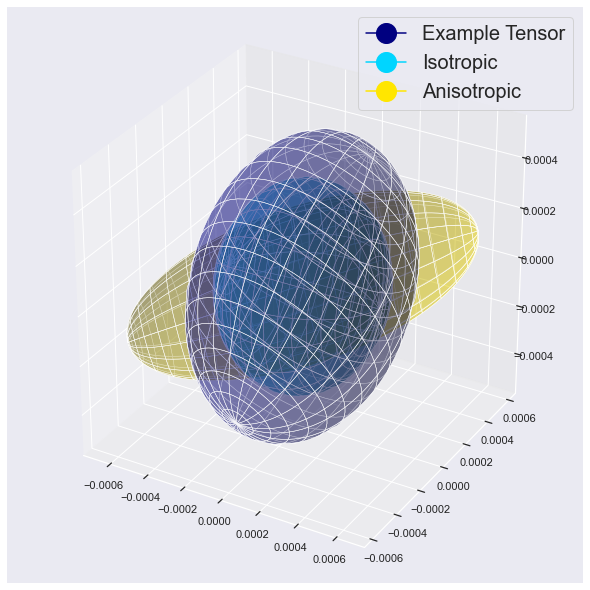

In [11]:
# Creating an anisotropic tensor
eig_vecs = ortho_group.rvs(dim=3)
eig_vals = np.diag(np.array([0.0002, 0.0004, 0.0008]))
anisotropic_tensor = np.dot(eig_vecs, np.dot(eig_vals, np.linalg.inv(eig_vecs)))

# Creating an isotropic tensor
eig_vecs = ortho_group.rvs(dim=3)
eig_vals = np.diag(np.array([0.0004,0.0004,0.0004]))
isotropic_tensor = np.dot(eig_vecs, np.dot(eig_vals, np.linalg.inv(eig_vecs)))

plot_tensor([tensor,isotropic_tensor, anisotropic_tensor], descriptions=["Example Tensor", "Isotropic", "Anisotropic"])

Our example tensor looks like an isotropic tensor. We can see that the anisotropic tensor is more elongated, representing a high diffusion constraint in its direction.

## Visualizing Scalar Maps

To vizualize and process DTI, **it's a common practice to first compute scalar maps** like fractional anisotropy or mean diffusivity. These maps can be visualized like standard images. **Each voxel of such images represent a ratio of the eigenvalues of the associated tensor.** In other word, to compute these maps, we first need to decompose each tensor into eigenvectors and eigenvalues and then compute the desired ratio. **Most of the Deep Learning litterature related to DTI use such maps** as input. However, **they do not consider the orientation of the tensor.**

### Mean Diffusivity

Mean diffusivity (MD) or trace is a scalar measure of the total diffusion within a voxel. These measures are commonly used clinically to localize white matter lesions that do not show up on other forms of clinical MRI.

**MD is computed with:** $MD=\frac{\lambda_{1} + \lambda_{2} + \lambda_{3}}{3}$, with $\lambda_{1}, \lambda_{2}, \lambda_{3}$ being the eigenvalues of each tensor.

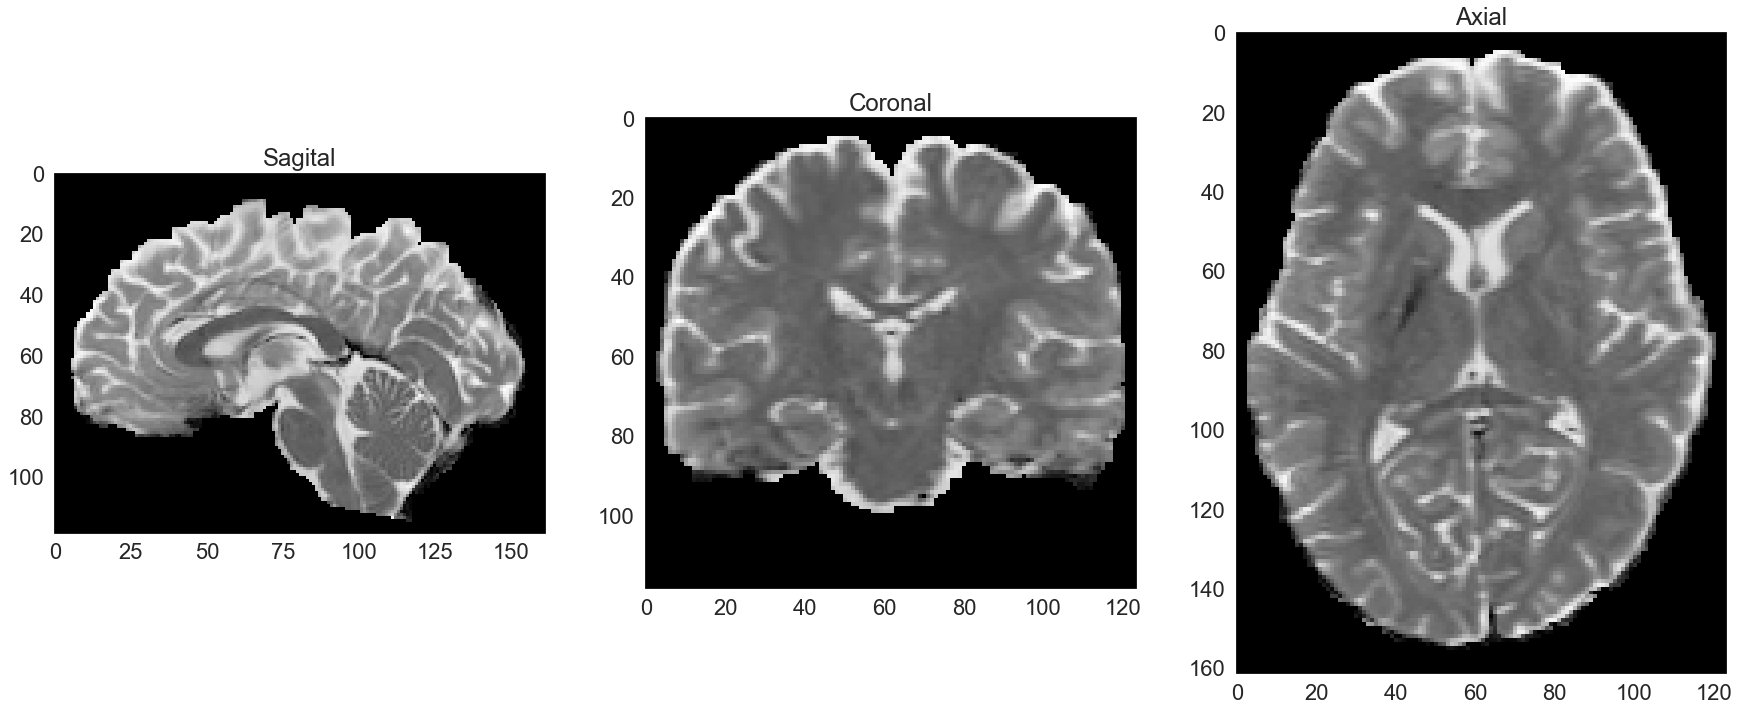

In [12]:
# Complete the function that convert a DTI slice into its MD scalar map
def compute_md(dti: np.array):
    md = np.zeros(dti.shape[1:])
    
    # Decompose tensors and compute their MD value
    for line in range(md.shape[0]):
        for col in range(md.shape[1]):
            eig_vals, eig_vecs = np.linalg.eigh(dti[:,line,col].reshape(3,3))
            md[line, col] = eig_vals.mean()
            
    return md

# Compute the MD maps for each slice
md_sagital = compute_md(ImageSlicer.get_slice(dti, SliceType.SAGITAL))
md_coronal = compute_md(ImageSlicer.get_slice(dti, SliceType.CORONAL))
md_axial = compute_md(ImageSlicer.get_slice(dti, SliceType.AXIAL))

plot_slices(md_sagital, md_coronal, md_axial, cmap="Greys_r")

### Fractional Anisotropy

Fractional anisotropy (FA) is an index for the amount of diffusion asymmetry within a voxel, defined in terms of its eigenvalues:

$$FA = \sqrt{\frac{(\lambda_{1}-\lambda_{2})^{2} + (\lambda_{2}-\lambda_{3})^{2} + (\lambda_{1}-\lambda_{3})^{2}}{2 (\lambda_{1}^{2} + \lambda_{2}^{2} + \lambda_{3}^{2})}}$$

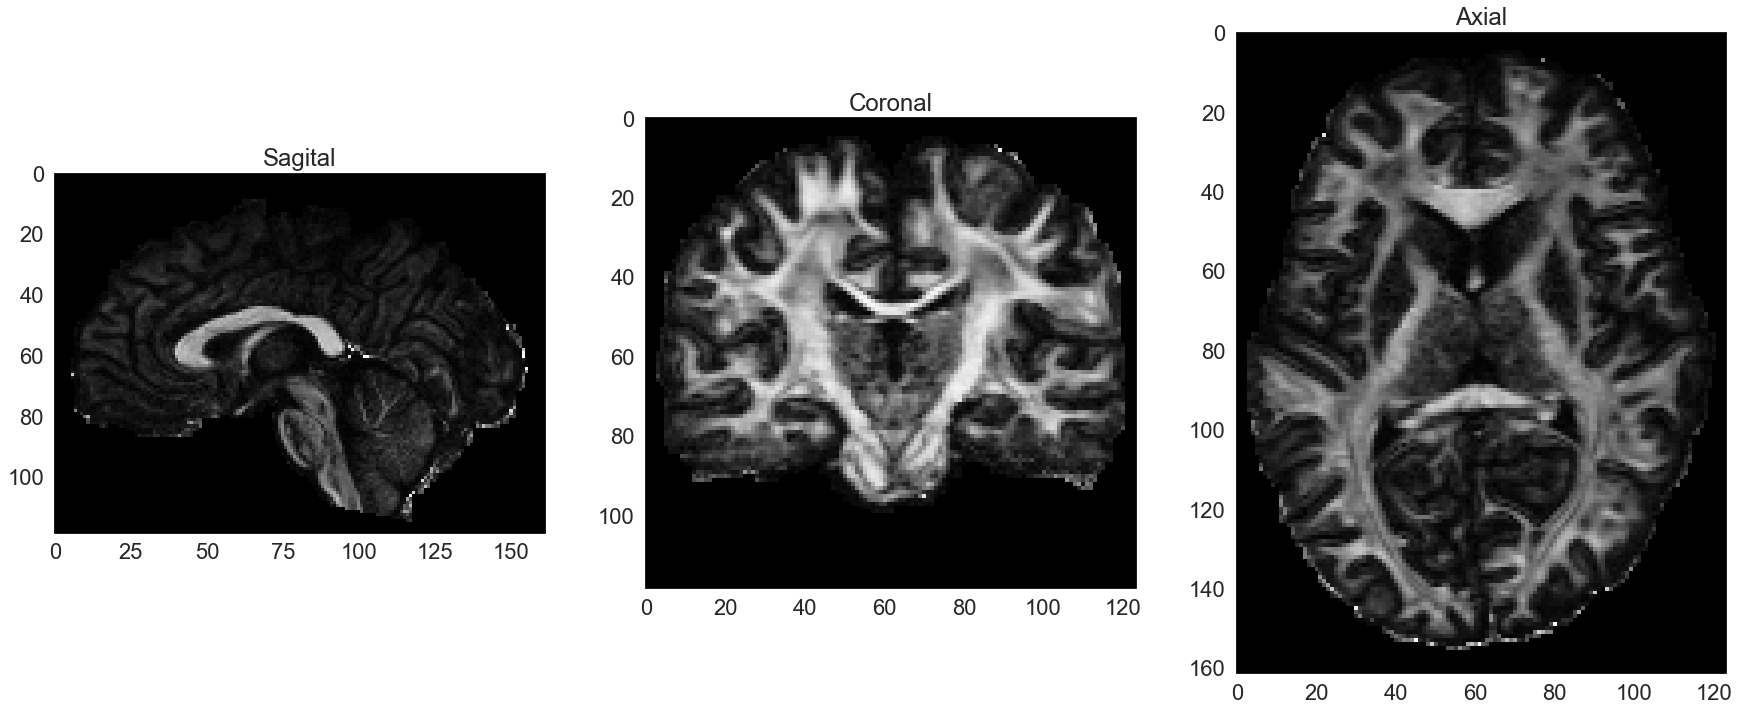

In [13]:
# Complete the function that convert a DTI slice into its FA scalar map
def compute_fa(dti: np.array):
    fa = np.zeros(dti.shape[1:])
    
    # Decompose tensors and compute their FA value
    for line in range(fa.shape[0]):
        for col in range(fa.shape[1]):
            eig_vals, eig_vecs = np.linalg.eigh(dti[:,line,col].reshape(3,3))
            num = (eig_vals[0] - eig_vals[1])**2 + (eig_vals[1] - eig_vals[2])**2 + (eig_vals[0] - eig_vals[2])**2
            denom = 2.0 * (eig_vals[2]**2 + eig_vals[1]**2 + eig_vals[0]**2)
            fa[line,col] = np.sqrt(num/denom) if denom != 0 else 0
            
    return fa

# Compute the FA maps for each slice
fa_sagital = compute_fa(ImageSlicer.get_slice(dti, SliceType.SAGITAL))
fa_coronal = compute_fa(ImageSlicer.get_slice(dti, SliceType.CORONAL))
fa_axial = compute_fa(ImageSlicer.get_slice(dti, SliceType.AXIAL))

plot_slices(fa_sagital, fa_coronal, fa_axial, cmap="Greys_r")

### Colored FA

This is a map that assigns colors to voxels based on a **combination of anisotropy and direction.** It is also called the colored fractional anisotropy map, fiber direction map or diffusion texture map. The color assignment is arbitrary, but the typical convention is to have the orientation of the principal eigenvector (ε1) control hue and fractional anisotropy (FA) control brightness.

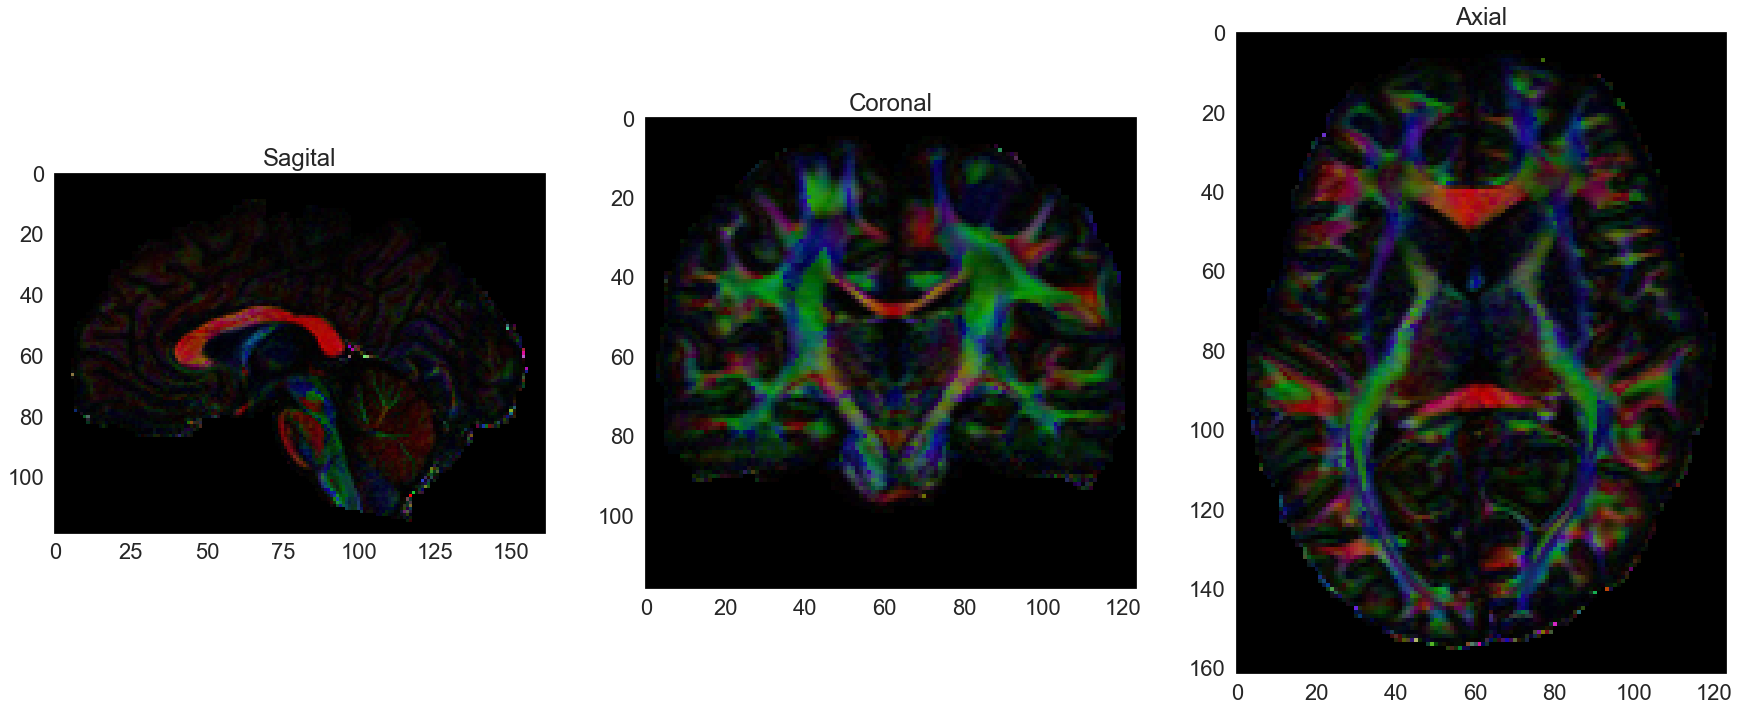

In [14]:
# Complete the function that convert a DTI slice into its colored FA scalar map. You can resuse the FA maps computed before
def compute_colored_fa(dti: np.array, fa: np.array):
    color_map = np.zeros((dti.shape[1],dti.shape[2], 3))
    
    # Decompose tensors and compute their FA value
    for line in range(fa.shape[0]):
        for col in range(fa.shape[1]):
            eig_vals, eig_vecs = np.linalg.eigh(dti[:,line,col].reshape(3,3))
            color_map[line,col,:] = np.flip(np.abs(eig_vecs[0,:]))
            
    return color_map * np.repeat(np.expand_dims(fa, 2),3 ,axis=2)

# Compute the FA maps for each slice
colored_fa_sagital = compute_colored_fa(ImageSlicer.get_slice(dti, SliceType.SAGITAL), fa_sagital)
colored_fa_coronal = compute_colored_fa(ImageSlicer.get_slice(dti, SliceType.CORONAL), fa_coronal)
colored_fa_axial = compute_colored_fa(ImageSlicer.get_slice(dti, SliceType.AXIAL), fa_axial)

plot_slices(colored_fa_sagital, colored_fa_coronal, colored_fa_axial)

## Part #2 Log-Euclidean Framework

Each voxel of a DT image is composed of a **diffusion tensor belonging to the Riemannian manifold of symmetric positive definite 3 x 3 matrices SPD(3).** 

<img src="images/manifold.png" width="400" vertical-align="bottom">


Because of their non-Euclidean nature, one **cannot simply use Euclidean operation on DT images.** In order to process DT images, **a Riemmannian metric must be used.** On of them is called the **Log-Euclidean metric.** Once in the Log-Euclidean domain, DTI can be processed (e.g. interpolation, deep learning methods, etc.) like real-valued images. To project DTI in the Log-Euclidean domain, we decompe every tensor, take the $log$ of th eigenvalues and reconstruct the tensor. To bring back the DTI to its original domain, we decompose every tensor, take the $exp$ of the eigenvalues and reconstruct the tensor as follows:

$$log(D) = Ulog(V)U^{T}$$
$$exp(log(D)) = Uexp(log(V))U^{T}$$

The $log$ and $exp$ mapping is equivalent to **projecting every tensor on the tangeant plane at the 3x3 identity matrix.**

<img src="images/identity_projection.png" width="800" vertical-align="bottom">

### Log-Euclidean Computation

In [15]:
# Complete the function that convert a DTI slice into the Log-Euclidean domain
def to_log_euclidean(dti: np.array):
    log_dti = np.zeros(dti.shape)
    
    # Decompose tensors and compute their Log-Euclidean
    for line in range(dti.shape[1]):
        for col in range(dti.shape[2]):
            tensor = dti[:,line,col].reshape(3,3)
            
            # Do not compute the Log-Euclidean of background tensor. It would lead to log(0) which is undef
            if np.any(tensor):
                eig_vals, eig_vecs = np.linalg.eigh(tensor)
                # Ignore tensors with negative eigenvalues for now
                if not np.any(eig_vals < 0):
                    log_dti[:,line,col] = np.dot(np.dot(eig_vecs, np.diag(np.log(eig_vals))),np.linalg.inv(eig_vecs)).reshape(9)
            
    return log_dti

# Compute the Log-Euclidean for each slice
log_dti_sagital = to_log_euclidean(ImageSlicer.get_slice(dti, SliceType.SAGITAL))
log_dti_coronal = to_log_euclidean(ImageSlicer.get_slice(dti, SliceType.CORONAL))
log_dti_axial = to_log_euclidean(ImageSlicer.get_slice(dti, SliceType.AXIAL))

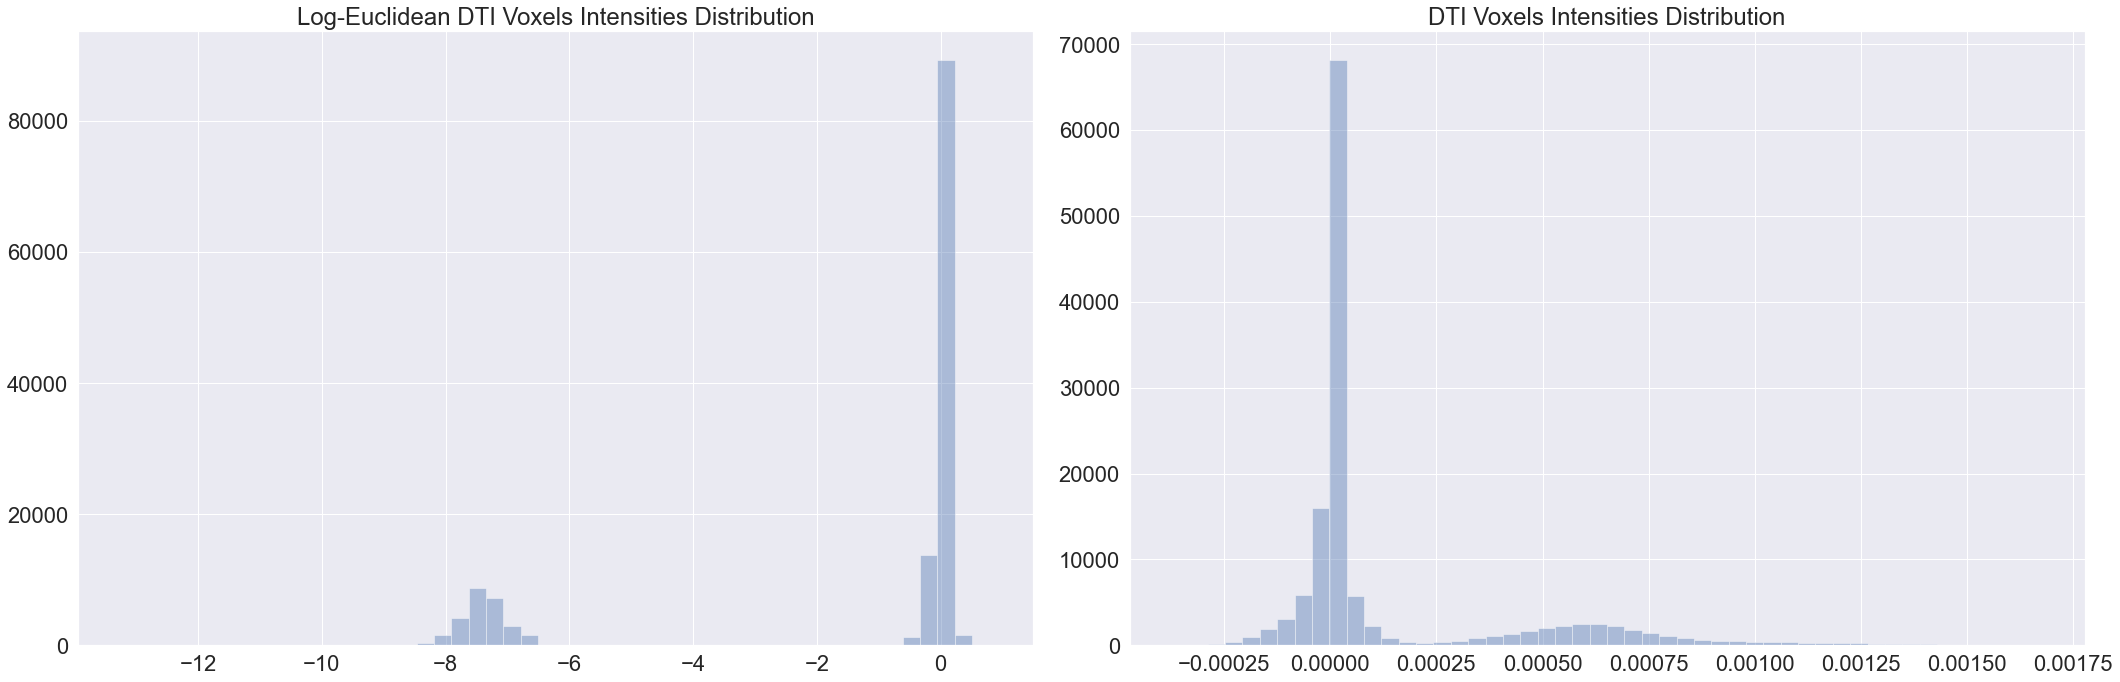

In [16]:
dti_coronal = ImageSlicer.get_slice(dti, SliceType.CORONAL)

sns.set(font_scale=2)
fig, ax = plt.subplots(1,2, figsize=(30,10))
sns.distplot(log_dti_coronal, bins=50, kde=False, ax=ax[0]).set_title("Log-Euclidean DTI Voxels Intensities Distribution")
sns.distplot(dti_coronal, bins=50, kde=False, ax=ax[1]).set_title("DTI Voxels Intensities Distribution")
plt.tight_layout()

As we can see in the two histograms above, the scale of the values of the Log-Euclidean tensor is much different than the scale of the regular DTI image.

In [17]:
# Complete the function that convert a Log-DTI back to the SPD(3) manifold using the exp mapping
def to_exp(log_dti: np.array):
    dti = np.zeros(log_dti.shape)
    
    # Decompose tensors and compute their Log-Euclidean
    for line in range(log_dti.shape[1]):
        for col in range(log_dti.shape[2]):
            tensor = log_dti[:,line,col].reshape(3,3)
            
            # Do not compute the exp of background tensors.
            if np.any(tensor):
                eig_vals, eig_vecs = np.linalg.eigh(tensor)
                dti[:,line,col] = np.dot(np.dot(eig_vecs, np.diag(np.exp(eig_vals))),np.linalg.inv(eig_vecs)).reshape(9)
            
    return dti

# Compute the Exp for each slice
rec_dti_coronal = to_exp(log_dti_coronal)

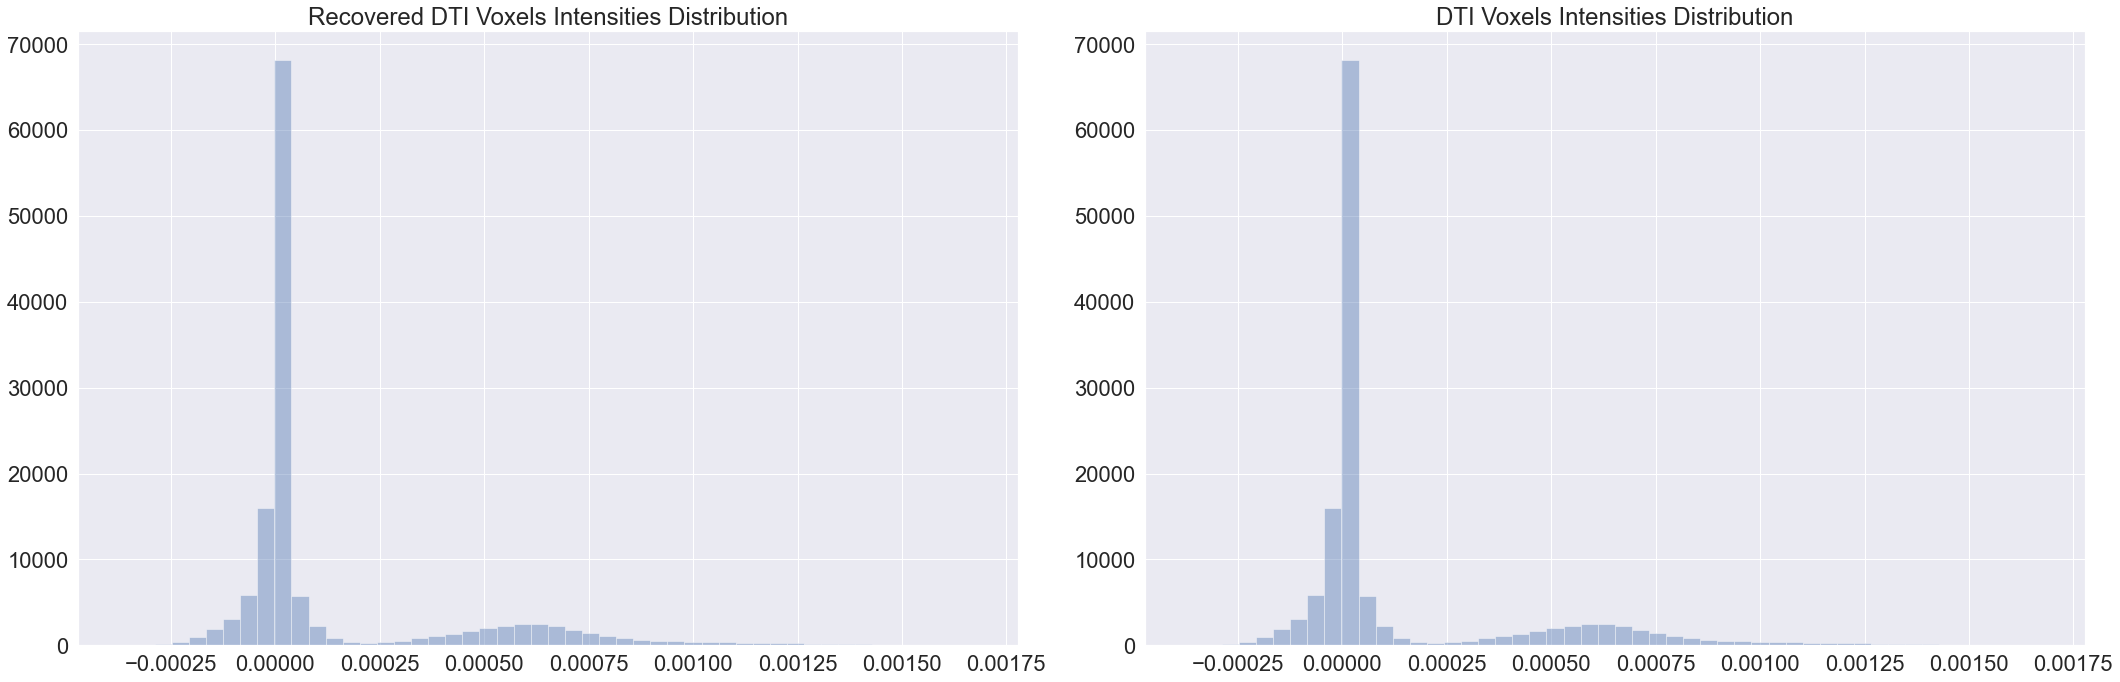

In [18]:
sns.set(font_scale=2)
fig, ax = plt.subplots(1,2, figsize=(30,10))
sns.distplot(rec_dti_coronal, bins=50, kde=False, ax=ax[0]).set_title("Recovered DTI Voxels Intensities Distribution")
sns.distplot(dti_coronal, bins=50, kde=False, ax=ax[1]).set_title("DTI Voxels Intensities Distribution")
plt.tight_layout()

By converting back the tensors using the Exp mapping, we recover the original intensities distribution.

### Fréchet Mean Computation

As the tensors lie on a manifold, taking the mean of multiple tensors is not equivalent as taking their arithmetic mean. A generalization of the mean on manifolds is called the **Fréchet Mean**.

In the Log-Euclidean domain, the **Fréchet Mean** is given by:

<img src="images/frechet_mean.gif" width="300" vertical-align="bottom">

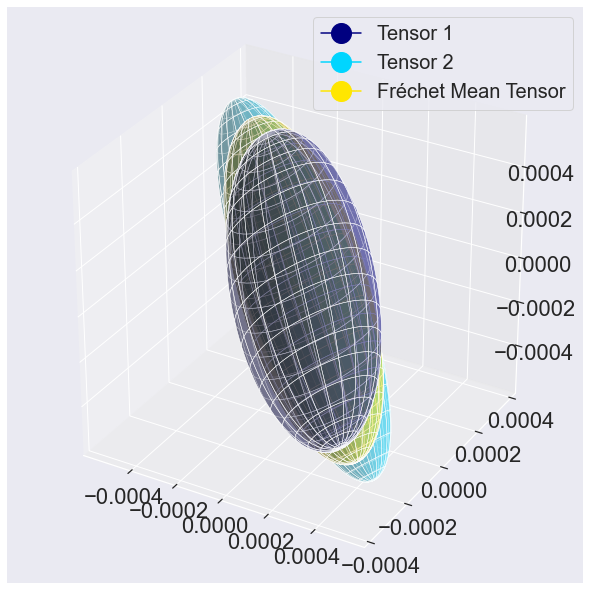

In [19]:
# Compute the Log-Euclidean of a 3x3 diffusion tensor
def to_log(tensor: np.array):
    eig_val, eig_vec = np.linalg.eigh(tensor)
    log_tensor = np.dot(np.dot(eig_vec, np.diag(np.log(eig_val))), eig_vec.T)
    
    return log_tensor

# Compute the exp of a 3x3 Log-Euclidean tensor
def to_exp(log_tensor: np.array):
    eig_val, eig_vec = np.linalg.eigh(log_tensor)
    tensor = np.dot(np.dot(eig_vec, np.diag(np.exp(eig_val))), eig_vec.T)
    
    return tensor

# Compute the frechet mean of a list of tensors using the Log-Euclidean framework
def compute_frechet_mean(tensors: List[np.array]):
    # Complete the method using the provided to_log and to_exp function above and the Fréchet Mean equation
    return to_exp(np.mean([to_log(tensor) for tensor in tensors], axis=0))

# Select random tensor
tensor_1, tensor_2 = dti[:, 50,75,50].reshape(3,3), dti[:,50,75,46].reshape(3,3)

# Compute the Fréchet mean using the Log-Euclidean framework
frechet_mean_tensor = compute_frechet_mean([tensor_1, tensor_2])

plot_tensor([tensor_1, tensor_2, frechet_mean_tensor], descriptions=["Tensor 1", "Tensor 2", "Fréchet Mean Tensor"])

### The *swelling* effect

In [20]:
euclidean_mean_tensor = (tensor_1 + tensor_2) / 2.0

frechet_eig_vals, frechet_eig_vecs = np.linalg.eigh(frechet_mean_tensor)
euclidean_eig_vals, euclidean_eig_vecs = np.linalg.eigh(euclidean_mean_tensor)

print("Fréchet mean eigenvalues: {}, Euclidean mean eigenvalues: {}".format(frechet_eig_vals, euclidean_eig_vals))

Fréchet mean eigenvalues: [0.00020826 0.00036623 0.00067861], Euclidean mean eigenvalues: [0.00021102 0.00036795 0.00068498]


We can see that the **eigenvalues of the decomposed Euclidean mean tensor are bigger than the eigenvalues of the Fréchet mean tensor.** This effect is known as the swelling effect. **When processing tensors in the Euclidean domain (not considering the manifold) some unwanted effect may arise like the increase of diffusion (swelling effect).**

## Part #3 Tractography and Fiber Bundle Segmentation

In neuroscience, tractography is a 3D modeling technique used to visually represent nerve tracts using data collected by diffusion MRI. The results are presented in two- and three-dimensional images called tractograms as follows:


<img src="images/tracto.jpeg" width="800" vertical-align="bottom">

Tractograms **provide interesting insight on whitematter that helps in the diagnostic of various disease and surgical planning.** Streamlines (nerve tracts) can be grouped in different bundles. This task known as fiber bundle segmentation provide additional information on the whitematter integrity. The dataset used in the [TractSeg paper](https://arxiv.org/ftp/arxiv/papers/1805/1805.07103.pdf) contains **72 different fiber bundles.**

<img src="images/fiber_bundle_segmentation.jpg" width="800" vertical-align="bottom">

### Fibertract Visualization (Arcuate fascicle Left)

The results of a tractogrphy algorithm are stored in a .trk file that can be visualize using [TrackVis](http://trackvis.org/). **Such file is present in the data folder of this github repo: AF_left.trk.**

At this point **I suggest installing TrackVis and visualizing the tractogram. You should observe something like this:**

<img src="images/af_left_tracto.PNG" width="500" vertical-align="bottom">

### Creating Fibertract Binary Mask

**To train a neural network that segment different fiber bundles, these tractogram must be converted to labels (72 classes).** To do so, we use the code available at [this repo](https://github.com/MIC-DKFZ/TractSeg).

In [21]:
# Compute the binary mask for the given tractogram. This output the binary mask in the space of the provided reference
# by applying its affine transform extracted from its header.
tract_to_binary(TRACT_IMAGE_PATH, BINARY_TRACT_IMAGE_PATH, BRAIN_MASK_IMAGE_PATH)

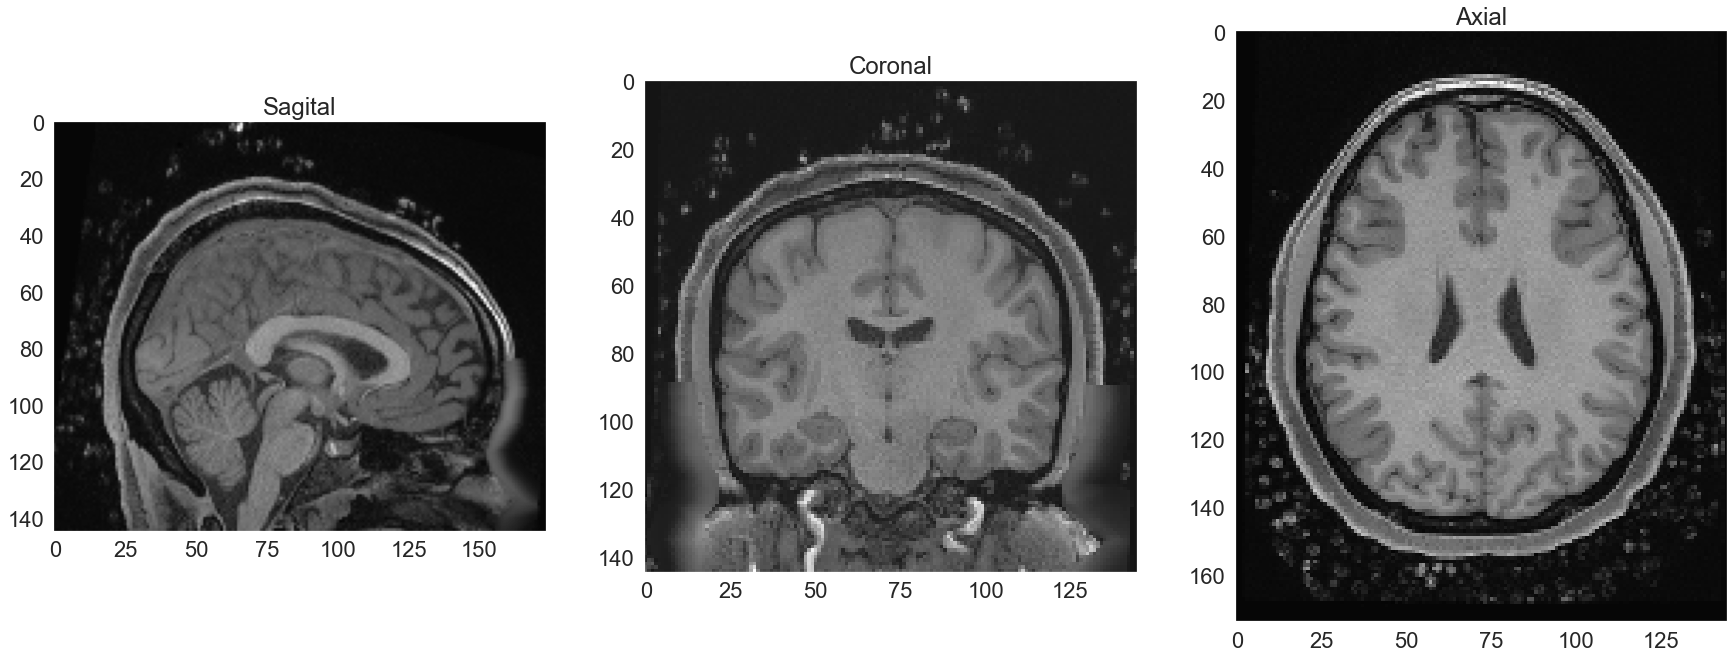

In [28]:
t1_mni = to_numpy_array(T1_MNI_IMAGE_PATH)

# Plot the reference T1 image
t1_MNI_sagital = ImageSlicer.get_slice(t1_mni, SliceType.SAGITAL, MNI_space=True)[0]
t1_MNI_coronal = ImageSlicer.get_slice(t1_mni, SliceType.CORONAL, MNI_space=True)[0]
t1_MNI_axial = ImageSlicer.get_slice(t1_mni, SliceType.AXIAL, MNI_space=True)[0]

plot_slices(t1_MNI_sagital,t1_MNI_coronal, t1_MNI_axial, cmap="Greys_r")

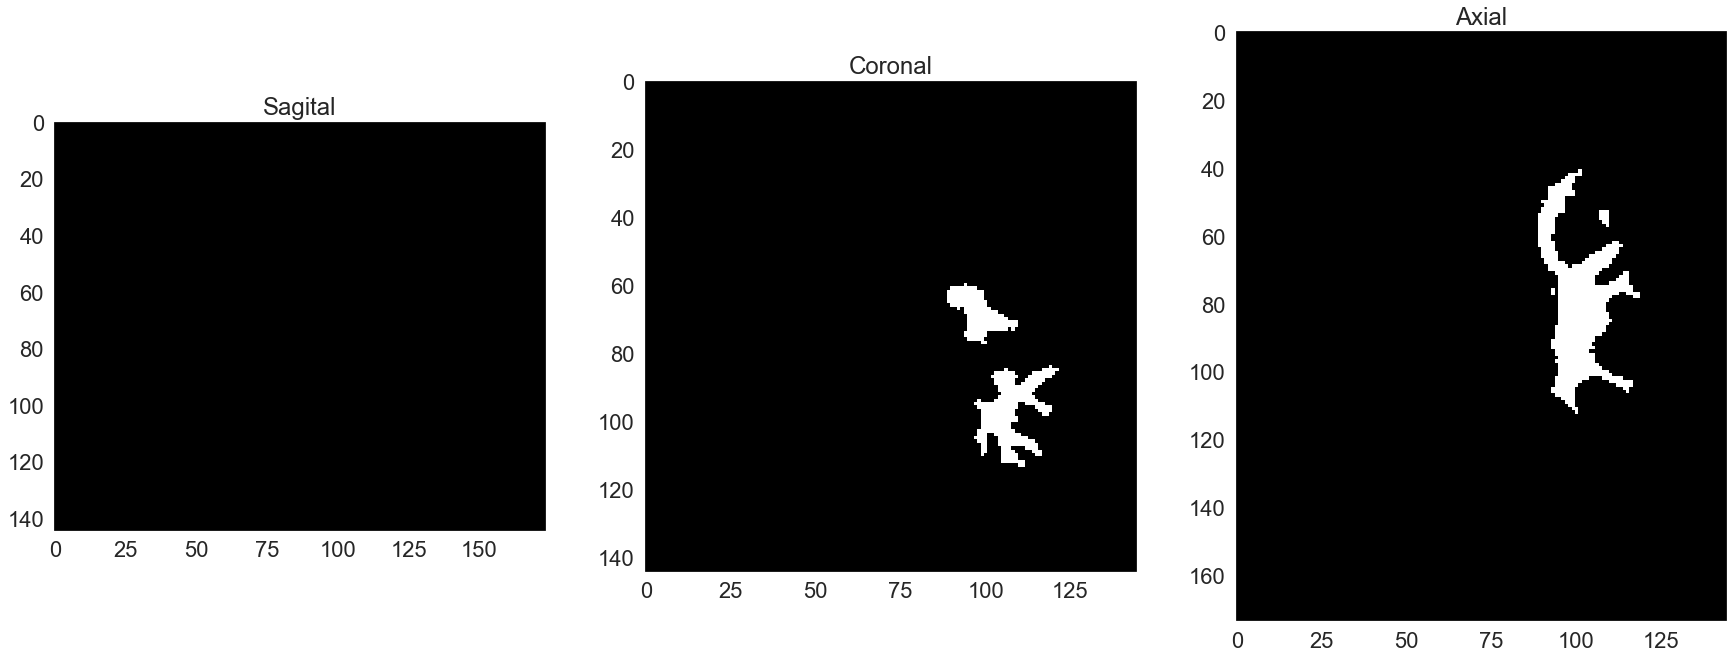

In [23]:
binary_tract = to_numpy_array(BINARY_TRACT_IMAGE_PATH)

# Plot the reference T1 image
binary_tract_sagital = ImageSlicer.get_slice(binary_tract, SliceType.SAGITAL, MNI_space=True)[0]
binary_tract_coronal = ImageSlicer.get_slice(binary_tract, SliceType.CORONAL, MNI_space=True)[0]
binary_tract_axial = ImageSlicer.get_slice(binary_tract, SliceType.AXIAL, MNI_space=True)[0]

plot_slices(binary_tract_sagital, binary_tract_coronal, binary_tract_axial, cmap="Greys_r")

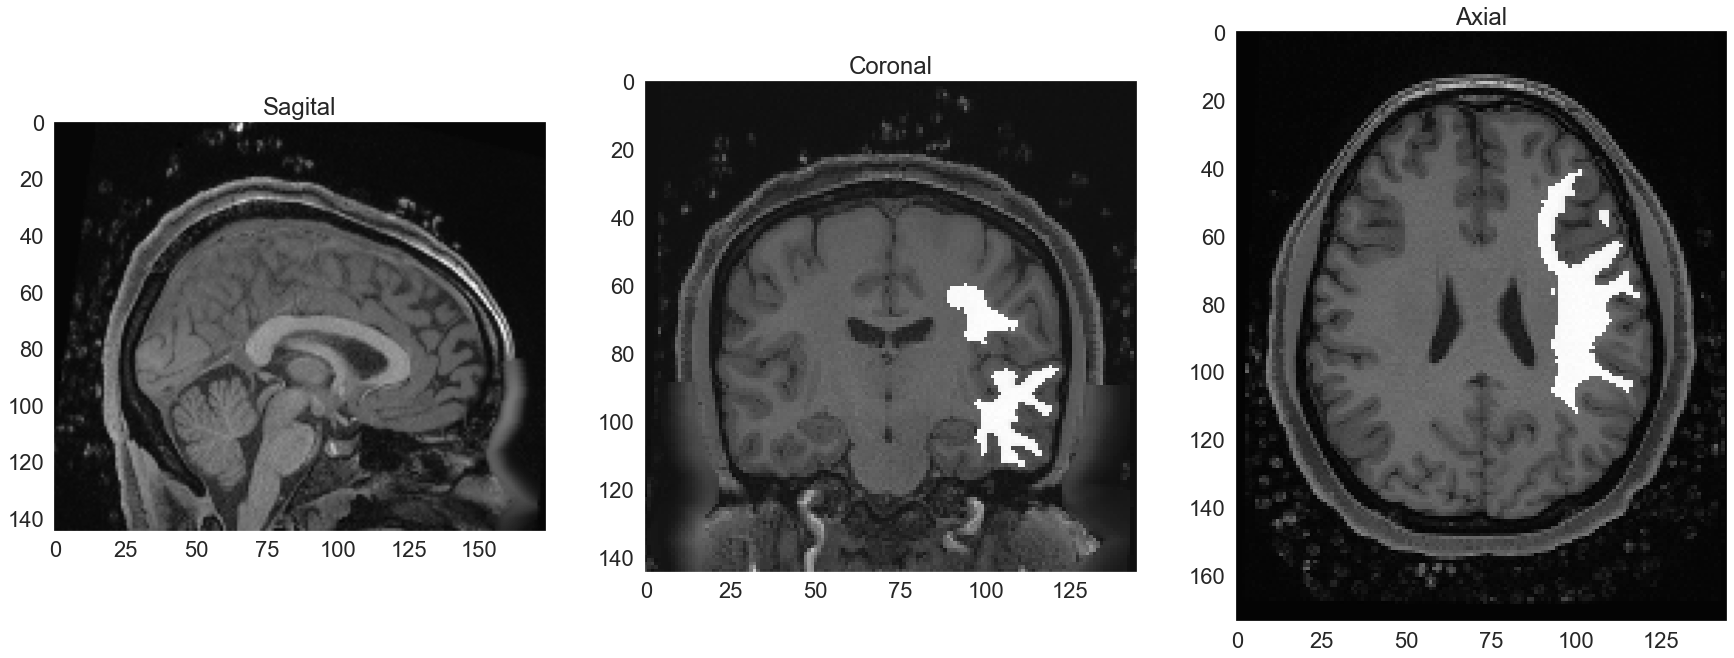

In [30]:
# Plot the segmented region
seg_sagital = t1_MNI_sagital + binary_tract_sagital
seg_coronal = (t1_MNI_coronal / t1_MNI_coronal.max())  + binary_tract_coronal
seg_axial = (t1_MNI_axial / t1_MNI_axial.max()) + binary_tract_axial

plot_slices(seg_sagital, seg_coronal, seg_axial, cmap="Greys_r")